## 背景
https://www.kaggle.com/c/california-house-prices/overview

## 分析
数据处理困难
- 数值较大
- 有文本特征（地址、介绍）
【目前直接丢弃了文本数据，待解决】

## 总结
MLP 目前rmse 0.4多

参考方法
运用了继承学习
- 第二和第七：https://www.bilibili.com/video/BV1rh411m7Hb?from=search&seid=14820697425740410884
- 第三h2o：https://www.kaggle.com/wuwawa/automl-using-h2o
- 第四 随机森林：https://www.kaggle.com/jackzh/the-4th-place-approach-random-forest

In [1]:
import os
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# get data
DATA_URL = os.path.join('..', 'data/california-house-prices')

train_data = pd.read_csv(os.path.join(DATA_URL, 'train.csv'))
test_data = pd.read_csv(os.path.join(DATA_URL, 'test.csv'))

train_data.shape, test_data.shape

((47439, 41), (31626, 40))

In [2]:
train_data.iloc[0:4, [0,1,2,3,4, -2, -1]]

,Id,Address,Sold Price,Summary,Type,Zip,State
0,0,540 Pine Ln,3825000.0,"540 Pine Ln, Los Altos, CA 94022 is a single f...",SingleFamily,94022,CA
1,1,1727 W 67th St,505000.0,"HURRY, HURRY.......Great house 3 bed and 2 bat...",SingleFamily,90047,CA
2,2,28093 Pine Ave,140000.0,'THE PERFECT CABIN TO FLIP! Strawberry deligh...,SingleFamily,95375,CA
3,3,10750 Braddock Dr,1775000.0,Rare 2-story Gated 5 bedroom Modern Mediterran...,SingleFamily,90230,CA


In [3]:
# =============== 数据预处理 ===============
'''
Sold Price [label] column_id=2
Summary 去掉
Address？分成门牌号+街道，街道one-hot
Listed On, Last Sold On,时间相关数据？分成day/month/year
此外暂时暴力解决 one-hot
heating cooling parking 有组合部分？
flooring 有组合 比较清晰
'''

# 去除列
all_features = pd.concat((train_data.drop(columns = ['Id', 'Sold Price', 'Summary']), 
                            test_data.drop(columns = ['Id', 'Summary'])))
'''
# 处理Address
all_features['Address'] = all_features['Address'].apply(
    lambda x: ' '.join(x.split(' ')[1:]))

# 拆分日期 Listed On, Last Sold On (空的怎么办)
def get_split(x, idx):
    if x is np.nan:
        return x
    else:
        return x.split()[0].split('-')[idx]
    
all_features['Listed On year'] = all_features['Listed On'].apply(
    lambda x: get_split(x, 0)).astype('float32')
all_features['Listed On month'] = all_features['Listed On'].apply(
    lambda x: get_split(x, 1)).astype('float32')
all_features['Listed On day'] = all_features['Listed On'].apply(
    lambda x: get_split(x, 2)).astype('float32')
all_features.drop(columns = 'Listed On')

all_features['Last Sold On year'] = all_features['Last Sold On'].apply(
    lambda x: get_split(x, 0)).astype('float32')
all_features['Last Sold On month'] = all_features['Last Sold On'].apply(
    lambda x: get_split(x, 1)).astype('float32')
all_features['Last Sold On day'] = all_features['Last Sold On'].apply(
    lambda x: get_split(x, 2)).astype('float32')
all_features.drop(columns = 'Last Sold On')
'''
# all_features.drop(columns = ['Address', 'Listed On', 'Last Sold On', 'Heating', 'Cooling'])


# 数值型
# 0均值单位方差，fillna
numeric_cols = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_cols] = all_features[numeric_cols].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_cols] = all_features[numeric_cols].fillna(0)

# 非数值型
# all_features = pd.get_dummies(all_features, dummy_na=True)
all_features = all_features[numeric_cols]

In [4]:
all_features

,Year built,Lot,Bathrooms,Full bathrooms,Total interior livable area,Total spaces,Garage spaces,Elementary School Score,Elementary School Distance,Middle School Score,Middle School Distance,High School Score,High School Distance,Tax assessed value,Annual tax amount,Listed Price,Last Sold Price,Zip
0,0.048505,-0.018489,-2.058002,0.000000,-0.006552,-0.135519,-0.123623,0.622758,-0.339282,0.000000,0.000000,0.929329,-0.318177,0.194780,0.305277,1.407144,0.000000,0.411159
1,-0.284656,-0.018287,-0.336769,-0.106424,-0.005198,-0.062731,-0.050507,-1.308481,-0.156142,-1.607235,-0.263072,-2.101186,-0.318177,-0.175090,-0.188125,-0.282410,-0.365086,-1.492275
2,-0.036722,-0.018031,0.523848,-1.167570,-0.004763,-0.135519,-0.123623,0.000000,0.000000,0.000000,0.000000,0.000000,2.350838,-0.616598,-0.639260,-0.441107,0.000000,1.059045
3,-0.121949,0.000000,0.523848,0.954722,-0.002493,-0.135519,-0.123623,1.588378,-0.430851,0.865487,-0.650772,0.929329,-0.651804,1.056241,0.945288,0.347781,0.795461,-1.404645
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.139948,3.369292,-0.123602,3.657007,-0.080842,2.502486,0.000000,0.000000,0.209783,0.201324,0.128637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31621,0.435902,0.000000,3.105697,0.000000,0.001650,-0.135519,0.095727,-0.342862,1.995746,0.865487,1.244651,0.424244,0.895012,4.007867,3.484043,3.386034,0.196868,1.354018
31622,0.056253,-0.018408,-0.336769,-1.167570,-0.005008,0.010056,-0.050507,-1.308481,-0.156142,0.370942,-0.349227,0.000000,-0.439496,-0.376933,-0.426599,-0.372108,-0.365086,-0.529784
31623,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.105568,0.667985,-1.112691,0.340017,-0.585928,0.409736,0.000000,0.000000,-0.320129,0.000000,-0.585330
31624,0.164724,0.000000,0.523848,-0.106424,-0.004334,0.010056,0.022610,0.622758,-0.064573,-0.618146,-0.349227,-0.080842,-0.196858,-0.340615,-0.361327,-0.319209,-0.224474,-0.490518


In [5]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
train_labels = torch.tensor(train_data['Sold Price'].values.reshape(-1, 1), dtype=torch.float32)
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)

In [6]:
train_features.shape, train_labels.shape, test_features.shape

(torch.Size([47439, 18]), torch.Size([47439, 1]), torch.Size([31626, 18]))

In [7]:
# =============== 训练 ===============
    
loss = nn.MSELoss()

def log_rmse(net, features, labels):
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels))) # loss function默认返回loss的均值
    return rmse.item() # tensor->number

def train(net, train_features, train_labels, test_features, test_labels,
             num_epochs, learning_rate, weight_decay, batch_size):
    train_ls, test_ls = [], []
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        # 记录ls 用于画图
        train_ls.append(log_rmse(net, train_features, train_labels))
        # print(f'epoch={epoch+1}, train_loss={train_ls[-1]}')
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

In [8]:
class my_net(nn.Module):
    def __init__(self, num_inputs):
        super().__init__()
        self.lin1 = nn.Linear(num_inputs, 16)
        self.lin2 = nn.Linear(16, 1)
        
    def forward(self, X):
        return self.lin2(F.relu(self.lin1(X)))

折1，训练log rmse0.515755, 验证log rmse0.499101
折2，训练log rmse0.487693, 验证log rmse0.471435


KeyboardInterrupt: 

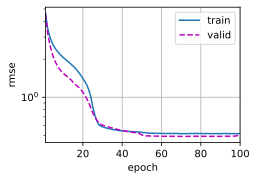

In [9]:
num_inputs = train_features.shape[-1]
net = my_net(num_inputs)

k, num_epochs, lr, weight_decay, batch_size = 5, 100, 0.1, 10, 256

train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')